# Recommendation System Project


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import dask.dataframe as dd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import joblib
import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares 

#### EXPLORATORY DATA ANALYSIS

In [4]:


# Load raw CSV files
events_df = pd.read_csv("events.csv")
item_properties_1 = pd.read_csv("item_properties_part1.1.csv")
item_properties_2 = pd.read_csv("item_properties_part2.csv")
category_tree = pd.read_csv("category_tree.csv")

# Merge item properties (since it's split into two parts)
item_properties = pd.concat([item_properties_1, item_properties_2])

# Display basic info
print("Events Dataset Info:")
events_df.info()
print("\nItem Properties Dataset Info:")
item_properties.info()
print("\nCategory Tree Dataset Info:")
category_tree.info()


Events Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB

Item Properties Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB

Category Tree Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    164

In [3]:
# Check missing values in all datasets
print("Missing Values in Events Dataset:")
print(events_df.isnull().sum())

print("\nMissing Values in Item Properties Dataset:")
print(item_properties.isnull().sum())

print("\nMissing Values in Category Tree Dataset:")
print(category_tree.isnull().sum())


Missing Values in Events Dataset:
timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

Missing Values in Item Properties Dataset:
timestamp    0
itemid       0
property     0
value        0
dtype: int64

Missing Values in Category Tree Dataset:
categoryid     0
parentid      25
dtype: int64


Summary Statistics

In [5]:
# Summary statistics for numerical columns
print(events_df.describe())



          timestamp     visitorid        itemid  transactionid
count  2.756101e+06  2.756101e+06  2.756101e+06   22457.000000
mean   1.436424e+12  7.019229e+05  2.349225e+05    8826.497796
std    3.366312e+09  4.056875e+05  1.341954e+05    5098.996290
min    1.430622e+12  0.000000e+00  3.000000e+00       0.000000
25%    1.433478e+12  3.505660e+05  1.181200e+05    4411.000000
50%    1.436453e+12  7.020600e+05  2.360670e+05    8813.000000
75%    1.439225e+12  1.053437e+06  3.507150e+05   13224.000000
max    1.442545e+12  1.407579e+06  4.668670e+05   17671.000000


In [ ]:
# If item properties contain numeric values:
print(item_properties.describe())
 

          timestamp        itemid
count  2.027590e+07  2.027590e+07
mean   1.435157e+12  2.333904e+05
std    3.327798e+09  1.348452e+05
min    1.431227e+12  0.000000e+00
25%    1.432436e+12  1.165160e+05
50%    1.433646e+12  2.334830e+05
75%    1.437880e+12  3.503040e+05
max    1.442113e+12  4.668660e+05


#### UNIVARIATE ANALYSIS

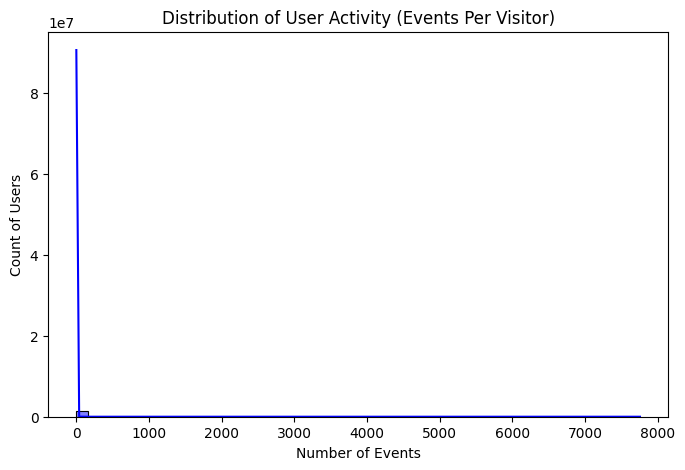

In [7]:
# Convert timestamp to datetime
events_df['datetime'] = pd.to_datetime(events_df['timestamp'], unit='ms')

# Plot distribution of visitor activity
plt.figure(figsize=(8, 5))
sns.histplot(events_df['visitorid'].value_counts(), bins=50, kde=True, color="blue")
plt.title("Distribution of User Activity (Events Per Visitor)")
plt.xlabel("Number of Events")
plt.ylabel("Count of Users")
plt.show()


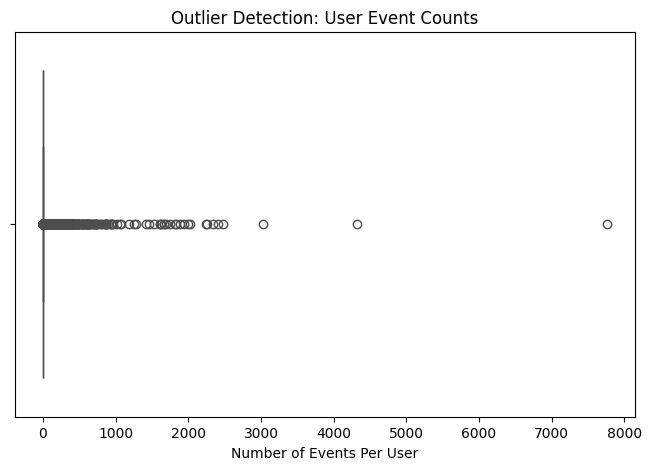

In [8]:
# Boxplot to detect extreme users
plt.figure(figsize=(8, 5))
sns.boxplot(x=events_df['visitorid'].value_counts(), color="red")
plt.title("Outlier Detection: User Event Counts")
plt.xlabel("Number of Events Per User")
plt.show()


### BIVARIATE ANALYSIS

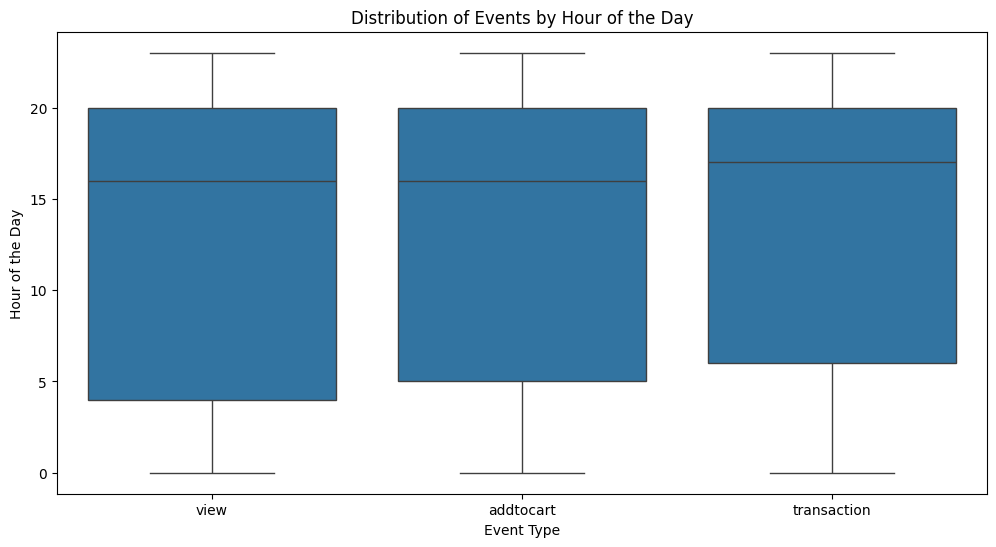

In [8]:
# Extract hour of the day
events_df['hour'] = events_df['datetime'].dt.hour

# Plot event counts by hour
plt.figure(figsize=(12, 6))
sns.boxplot(x="event", y="hour", data=events_df)
plt.title("Distribution of Events by Hour of the Day")
plt.xlabel("Event Type")
plt.ylabel("Hour of the Day")
plt.show()


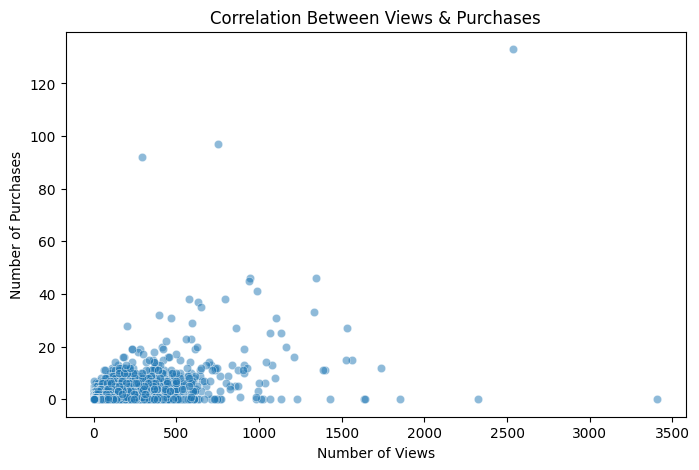

In [9]:
# Count how often each item was viewed vs purchased
view_counts = events_df[events_df['event'] == 'view'].groupby('itemid').size().reset_index(name="view_count")
purchase_counts = events_df[events_df['event'] == 'transaction'].groupby('itemid').size().reset_index(name="purchase_count")

# Merge to analyze the relationship
item_popularity = view_counts.merge(purchase_counts, on="itemid", how="left").fillna(0)

# Scatterplot to visualize correlation
plt.figure(figsize=(8, 5))
sns.scatterplot(x="view_count", y="purchase_count", data=item_popularity, alpha=0.5)
plt.title("Correlation Between Views & Purchases")
plt.xlabel("Number of Views")
plt.ylabel("Number of Purchases")
plt.show()


Which Item Categories are Purchased Most?

In [ ]:
# Define file paths
file_paths = ["item_properties_part1.1.csv", "item_properties_part2.csv"]

# Read in chunks and filter relevant properties
chunk_size = 500000  # Adjust for memory efficiency
item_properties_list = []

for file in file_paths:
    chunks = pd.read_csv(file, usecols=['timestamp', 'itemid', 'property', 'value'], chunksize=chunk_size)
    
    for chunk in chunks:
        # Keep only 'categoryid' and 'available' properties
        chunk = chunk[chunk['property'].isin(['categoryid', 'available'])]
        chunk['timestamp'] = pd.to_datetime(chunk['timestamp'], unit='ms')
        item_properties_list.append(chunk)

# Combine all chunks
item_properties = pd.concat(item_properties_list)

# Sort by timestamp to get the latest property values
item_properties = item_properties.sort_values(by=['itemid', 'timestamp'], ascending=[True, False])

# Remove duplicates: Keep only the latest property for each itemid-property pair
item_properties = item_properties.drop_duplicates(subset=['itemid', 'property'], keep='first')

# Pivot to get a single row per item
item_properties_pivot = item_properties.pivot(index='itemid', columns='property', values='value').reset_index()

# Convert categories to categorical types
item_properties_pivot['categoryid'] = item_properties_pivot['categoryid'].astype('category')
item_properties_pivot['available'] = item_properties_pivot['available'].astype(float).fillna(0).astype(int)

# Save cleaned version
item_properties_pivot.to_csv("chunked_item_properties.csv", index=False)

print("Processing complete! 🚀")


Processing complete! 🚀


In [16]:
# Load cleaned item properties
item_properties = pd.read_csv("chunked_item_properties.csv")

# Load events dataset (only required columns)
events_df = pd.read_csv("events.csv", usecols=['timestamp', 'visitorid', 'event', 'itemid'])

# Merge with item properties (Left Join: Keep all events, add item details)
events_with_properties = events_df.merge(item_properties, on="itemid", how="left")

# Save merged dataset
events_with_properties.to_csv("merged_chunked_item_properties_events.csv", index=False)

print("Merging complete! 🚀 File saved as 'merged_chunked_item_properties_events.csv'")


Merging complete! 🚀 File saved as 'merged_chunked_item_properties_events.csv'


C:\Users\DELL\AppData\Local\Temp\ipykernel_11412\3217388814.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("categoryid")['event']
C:\Users\DELL\AppData\Local\Temp\ipykernel_11412\3217388814.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="categoryid", y="event", data=category_sales, palette="viridis")


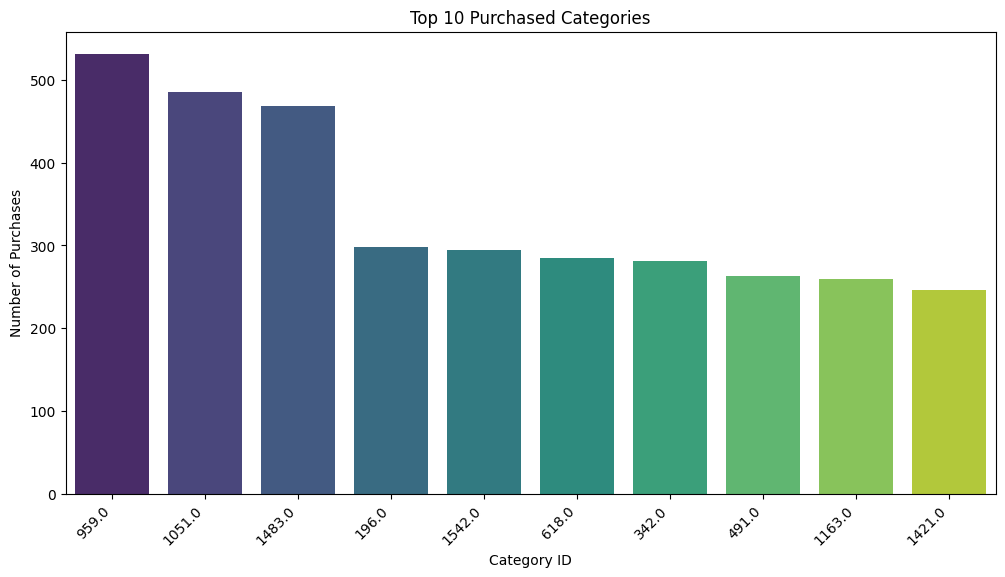

In [ ]:
# Load merged dataset
merged_chunked_events_df = pd.read_csv("merged_chunked_item_properties_events.csv")

# Ensure 'categoryid' is treated as a categorical variable
merged_chunked_events_df['categoryid'] = merged_chunked_events_df['categoryid'].astype('category')

# Count purchases by category
category_sales = (
    merged_chunked_events_df[merged_chunked_events_df['event'] == 'transaction']
    .groupby("categoryid")['event']
    .count()
    .reset_index()
)

# Sort and display top 10 purchased categories
category_sales = category_sales.sort_values("event", ascending=False).head(10)


# Convert categoryid to string (if it's numerical)
category_sales["categoryid"] = category_sales["categoryid"].astype(str)

# Plot results with adjusted labels
plt.figure(figsize=(12, 6))
sns.barplot(x="categoryid", y="event", data=category_sales, palette="viridis")

plt.title("Top 10 Purchased Categories")
plt.xlabel("Category ID")
plt.ylabel("Number of Purchases")

# Adjust x-axis labels
plt.xticks(rotation=45, ha="right")  # Rotate labels to avoid overlap
plt.show()


## Multivariate Analysis

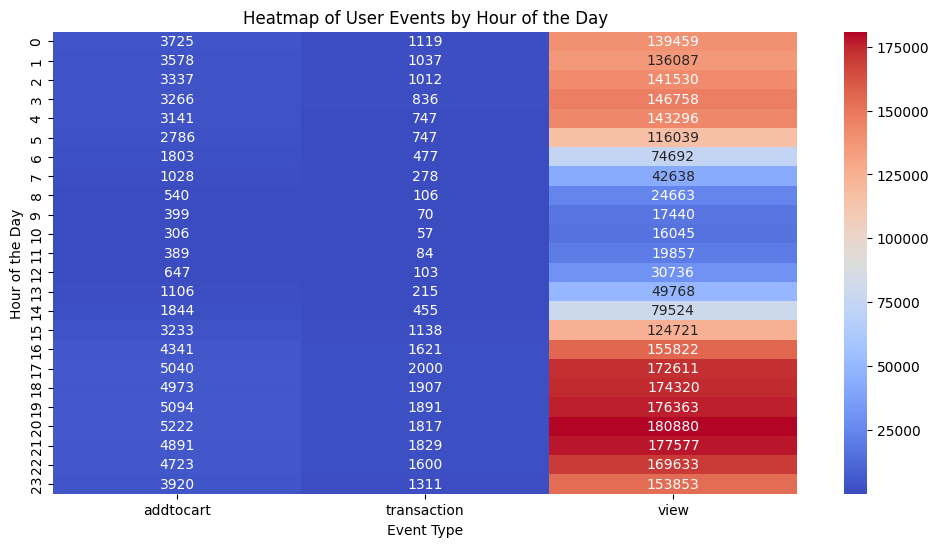

In [11]:
# Count transactions by hour and event type
hourly_events = events_df.groupby(["hour", "event"]).size().reset_index(name="count")

# Heatmap to visualize trends
plt.figure(figsize=(12, 6))
hour_pivot = hourly_events.pivot(index="hour", columns="event", values="count")  # ✅ Fixed pivot()
sns.heatmap(hour_pivot, cmap="coolwarm", annot=True, fmt="g")
plt.title("Heatmap of User Events by Hour of the Day")
plt.xlabel("Event Type")
plt.ylabel("Hour of the Day")
plt.show()


## DATA PREPROCESSING

In [18]:
item_properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [19]:
# Load datasets
item_properties_1 = pd.read_csv("item_properties_part1.1.csv")
item_properties_2 = pd.read_csv("item_properties_part2.csv")
events_df = pd.read_csv("events.csv")

# Merge item properties datasets
item_properties_df = pd.concat([item_properties_1, item_properties_2])




In [20]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [21]:
item_properties_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


In [22]:
# Check for missing values
print("Missing values in item_properties_df:")
print(item_properties_df.isnull().sum())

print("\nMissing values in events_df:")
print(events_df.isnull().sum())

Missing values in item_properties_df:
timestamp    0
itemid       0
property     0
value        0
dtype: int64

Missing values in events_df:
timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64


In [25]:
item_properties_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [26]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [23]:
# Check for duplicates
print("\nDuplicate rows in item_properties_df:", item_properties_df.duplicated().sum())
print("Duplicate rows in events_df:", events_df.duplicated().sum())



Duplicate rows in item_properties_df: 0
Duplicate rows in events_df: 460


In [30]:
# Check the shape (rows, columns) of both datasets
print("Shape of item_properties_df:", item_properties_df.shape)
print("Shape of events_df:", events_df.shape)


Shape of item_properties_df: (20275902, 4)
Shape of events_df: (2756101, 5)


In [31]:
# Drop duplicate rows in events_df
events_df = events_df.drop_duplicates()

# Check the shape (rows, columns) of the updated events dataset
print("Shape of events_df:", events_df.shape)


Shape of events_df: (2755641, 5)


In [43]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [41]:

# confirm changes
# Check for missing values
print("\nMissing values in events_df:")
print(events_df.isnull().sum())

# Check for duplicate rows
print("Duplicate rows in events_df:", events_df.duplicated().sum())



Missing values in events_df:
timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733184
dtype: int64
Duplicate rows in events_df: 0


In [44]:
# Save the cleaned event dataset
events_df.to_csv("cleaned_event.csv", index=False)

print("\nCleaning completed! File saved as 'cleaned_event.csv'.")





Cleaning completed! File saved as 'cleaned_event.csv'.


In [ ]:
# Load events dataset using Dask
events_df = dd.read_csv("cleaned_event.csv")

# Ensure item_properties_df is a Dask DataFrame (convert from Pandas if needed)
if not isinstance(item_properties_df, dd.DataFrame):
    item_properties_df = dd.from_pandas(item_properties_df, npartitions=10)  # Adjust partitions based on memory

# Merge events with item properties on 'itemid'
merged_df = dd.merge(events_df, item_properties_df, on="itemid", how="left")

In [50]:
# Compute the shape (rows, columns)
num_rows, num_cols = merged_df.shape
print(f"Shape of merged_df: ({num_rows.compute()}, {num_cols})")

Shape of merged_df: (28318907, 8)


In [46]:
#  Save the merged dataset to CSV
merged_df.to_csv("merged_events_item_properties_dask.csv", index=False, single_file=True)

print("Merging completed with Dask! File saved as 'merged_events_item_properties_dask.csv'.")


Merging completed with Dask! File saved as 'merged_events_item_properties_dask.csv'.


In [ ]:
merged_df.head()

,timestamp_x,visitorid,event,itemid,transactionid,timestamp_y,property,value
0,1433221999827,111016,view,318965,NaN,NaN,<NA>,NaN
1,1433221923240,810725,view,443030,NaN,1.431832e+12,categoryid,1098.0
2,1433221923240,810725,view,443030,NaN,1.431227e+12,available,1.0
3,1433223291897,794181,view,439202,NaN,1.431227e+12,categoryid,1542.0
4,1433223291897,794181,view,439202,NaN,1.431227e+12,available,1.0


In [57]:
merged_df.columns

Index(['timestamp_x', 'visitorid', 'event', 'itemid', 'transactionid',
       'property', 'value'],
      dtype='object')

In [ ]:
# Check for missing values
missing_values = merged_df.isnull().sum().compute()
print("Missing values in merged_df:\n", missing_values)

# Count total rows before dropping duplicates
total_rows_before = merged_df.shape[0].compute()

# Drop duplicates
merged_df_no_duplicates = merged_df.drop_duplicates()

# Count total rows after dropping duplicates
total_rows_after = merged_df_no_duplicates.shape[0].compute()

# Calculate duplicate count
duplicate_count = total_rows_before - total_rows_after
print("\nNumber of duplicate rows in merged_df:", duplicate_count)


Missing values in merged_df:
 timestamp_x             0
visitorid               0
event                   0
itemid                  0
transactionid    28008721
property           255576
value              255576
dtype: int64

Number of duplicate rows in merged_df: 21660915


In [ ]:
# Drop duplicate rows
merged_df = merged_df.drop_duplicates()

# Handle missing values
merged_df["property"] = merged_df["property"].fillna("Unknown")
merged_df["value"] = merged_df["value"].fillna("Unknown")
merged_df["transactionid"] = merged_df["transactionid"].fillna(0)  # Keep as 0 if no purchase

# Create `is_transaction` column
merged_df["is_transaction"] = merged_df["transactionid"].apply(lambda x: 1 if x != 0 else 0, meta=('x', 'int64'))

# Save the cleaned dataset
merged_df.to_csv("cleaned_merged_events_item_properties.csv", index=False, single_file=True)

print("\n✅ Cleaning completed! File saved as 'cleaned_merged_events_item_properties.csv'.")



✅ Cleaning completed! File saved as 'cleaned_merged_events_item_properties.csv'.


In [63]:
# confirm changes
# Compute the shape (rows, columns)
num_rows, num_cols = merged_df.shape
print(f"Shape of merged_df: ({num_rows.compute()}, {num_cols})")

Shape of merged_df: (6657992, 8)


In [64]:
merged_df.head()

,timestamp_x,visitorid,event,itemid,transactionid,property,value,is_transaction
53,1433220897977,1217827,view,203231,0.0,categoryid,84.0,0
467,1433216876714,1205474,view,123986,0.0,categoryid,1663.0,0
553,1433218154553,1041483,view,89977,0.0,categoryid,516.0,0
743,1433173152057,556273,view,152085,0.0,available,1.0,0
813,1433173362711,294858,view,245879,0.0,categoryid,47.0,0


## FEATURE ENGINEERING

### ANOMALY DETECTION

In [ ]:
# Load dataset
events_df = dd.read_csv("events.csv")

# Convert timestamp to datetime
events_df["timestamp"] = dd.to_datetime(events_df["timestamp"], unit="ms")

# Check first few rows
events_df.head()


,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


COMPUTE USER ACTIVITY

In [37]:
import dask.dataframe as dd

# Group by visitorid and compute the number of events per user
user_activity = events_df.groupby("visitorid").agg(
    event_count=("event", "count"),  # Total number of events
    first_event=("timestamp", "min"),  # First recorded event
    last_event=("timestamp", "max")   # Last recorded event
).reset_index()

# Compute session duration (time span of activity)
user_activity["session_duration"] = (user_activity["last_event"] - user_activity["first_event"]).dt.total_seconds()

# Display results
user_activity.head()


,visitorid,event_count,first_event,last_event,session_duration
0,257597,2,2015-06-02 05:02:12.117,2015-06-08 22:00:21.247,579489.130
1,992329,30,2015-05-05 05:06:24.830,2015-07-30 16:23:01.735,7470996.905
2,111016,2,2015-05-31 02:27:57.492,2015-06-02 05:13:19.827,182722.335
3,483717,3,2015-06-02 05:10:04.507,2015-06-02 05:12:35.914,151.407
4,951259,1,2015-06-02 05:02:17.106,2015-06-02 05:02:17.106,0.000


In [ ]:
# Define thresholds for bot detection
event_threshold = user_activity["event_count"].quantile(0.99)  # Top 1% most active users
duration_threshold = 1  # Users with session duration < 1 second

# Identify bot users
bot_users = user_activity[
    (user_activity["event_count"] > event_threshold) | 
    (user_activity["session_duration"] < duration_threshold)
]["visitorid"].compute()

print(f"Identified {len(bot_users)} potential bots.")

# Remove bot users from the events dataset
events_cleaned = events_df[~events_df["visitorid"].isin(bot_users)]
print(f"Remaining users after bot removal: {events_cleaned['visitorid'].nunique().compute()}")

# Save cleaned dataset
events_cleaned.to_csv("cleaned_events.csv", index=False, single_file=True)
print("\n✅ Bot detection & removal complete! File saved as 'cleaned_events.csv'.")


Identified 1015778 potential bots.
Remaining users after bot removal: 391802

✅ Bot detection & removal complete! File saved as 'cleaned_events.csv'.


EXTRACT TIME-BASED FEATURES

In [ ]:
# Load dataset
events_df = dd.read_csv("cleaned_events.csv")

# Convert `timestamp` column to datetime
events_df["timestamp"] = dd.to_datetime(events_df["timestamp"], errors="coerce")

# Extract time-based features
events_df["hour"] = events_df["timestamp"].dt.hour
events_df["day_of_week"] = events_df["timestamp"].dt.dayofweek
events_df["month"] = events_df["timestamp"].dt.month

# Save the updated dataset
events_df.to_csv("events_with_time_features.csv", index=False, single_file=True)

print("\n✅ Time-based feature extraction complete! File saved as 'events_with_time_features.csv'.")



✅ Time-based feature extraction complete! File saved as 'events_with_time_features.csv'.


ENCODE CATEGORICAL FEATURES

In [ ]:
# Load the dataset
events_df = dd.read_csv("events_with_time_features.csv")

# Fill missing values in `event` column with a placeholder
events_df["event"] = events_df["event"].fillna("Unknown")

# Convert to string type explicitly
events_df["event"] = events_df["event"].astype(str)

# Apply Label Encoding
event_encoder = LabelEncoder()
events_df["event_encoded"] = events_df["event"].map_partitions(lambda x: event_encoder.fit_transform(x), meta=('event_encoded', 'int64'))

# Convert `category_id` to integer (if applicable)
if "category_id" in events_df.columns:
    events_df["category_id"] = events_df["category_id"].astype("int64")

# Save the updated dataset
events_df.to_csv("events_encoded.csv", index=False, single_file=True)

print("\n✅ Categorical feature encoding complete! File saved as 'events_encoded.csv'.")



✅ Categorical feature encoding complete! File saved as 'events_encoded.csv'.


COMPUTE USER INTERACTION

In [ ]:
# Load dataset
events_df = dd.read_csv("events_encoded.csv")

# Ensure timestamp is datetime
events_df["timestamp"] = dd.to_datetime(events_df["timestamp"])

# Compute total number of events per user
events_df["total_events"] = events_df.groupby("visitorid")["event"].transform("count")

# Compute session count
events_df["session_count"] = events_df.groupby("visitorid")["timestamp"].transform("nunique")

# Sort by visitorid and timestamp
events_df = events_df.sort_values(["visitorid", "timestamp"])

# Function to compute `time_since_last_event`
def compute_time_diff(df):
    df["time_since_last_event"] = df.groupby("visitorid")["timestamp"].diff().dt.total_seconds().fillna(0)
    return df

# Apply function
events_df = events_df.map_partitions(compute_time_diff)

# ✅ **Reorder columns to match metadata**
column_order = [
    "timestamp", "visitorid", "event", "itemid", "transactionid",
    "event_encoded", "day_of_week", "hour", "month",
    "total_events", "session_count", "time_since_last_event"
]
events_df = events_df[column_order]  # Reorder explicitly

# Save the updated dataset
events_df.to_csv("events_with_user_features.csv", index=False, single_file=True)

print("\n✅ User interaction feature extraction complete! File saved as 'events_with_user_features.csv'.")


C:\Users\DELL\AppData\Local\Temp\ipykernel_14696\3287632040.py:10: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  events_df["total_events"] = events_df.groupby("visitorid")["event"].transform("count")
C:\Users\DELL\AppData\Local\Temp\ipykernel_14696\3287632040.py:13: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  events_df["session_count"] = events_df.groupby("visitorid")["timestamp"].transform("nunique")



✅ User interaction feature extraction complete! File saved as 'events_with_user_features.csv'.


In [ ]:
# Load the dataset
events_df = dd.read_csv("events_with_user_features.csv", dtype={"visitorid": "int64", "itemid": "int64"})

# Ensure timestamp is in datetime format
events_df["timestamp"] = dd.to_datetime(events_df["timestamp"])

# Define function to compute time difference within each partition
def compute_time_diff(df):
    df = df.sort_values(["visitorid", "itemid", "timestamp"])
    df["time_spent"] = df.groupby(["visitorid", "itemid"])["timestamp"].diff().dt.total_seconds()
    df["time_spent"] = df["time_spent"].fillna(0)
    return df

# ✅ Update metadata to include `time_spent`
meta = events_df._meta.copy()
meta["time_spent"] = 0.0  # Define expected type (float)

# Apply function using map_partitions with correct metadata
events_df = events_df.map_partitions(compute_time_diff, meta=meta)

# Save the updated dataset
events_df.to_csv("events_with_interaction_features.csv", index=False, single_file=True)

print("\n✅ User-item interaction features extracted! File saved as 'events_with_interaction_features.csv'.")



✅ User-item interaction features extracted! File saved as 'events_with_interaction_features.csv'.


MERGE ITEM PROPERTIES

Load & Clean Item Properties Data

Merge item_properties_part1.1.csv and item_properties_part2.csv.

Handle missing values and duplicates.

In [ ]:

# Load events_with_interaction_features.csv (processed events data)
events_df = dd.read_csv("events_with_interaction_features.csv", dtype={'transactionid': 'object'})

# Load and merge item properties from two parts
item_part1 = dd.read_csv("item_properties_part1.1.csv", dtype={'property': 'object', 'value': 'object'})
item_part2 = dd.read_csv("item_properties_part2.csv", dtype={'property': 'object', 'value': 'object'})

# Merge both item properties datasets and remove duplicates
item_properties = dd.concat([item_part1, item_part2]).drop_duplicates()


In [4]:
# Merge events data with item properties
merged_df = events_df.merge(item_properties, on="itemid", how="left")

# Save in multiple smaller files to avoid memory errors
merged_df.to_csv("merged_events_with_item_properties_*.csv", index=False, single_file=False)


['d:\\recommend\\Recommendation_Systems\\merged_events_with_item_properties_00.csv',
 'd:\\recommend\\Recommendation_Systems\\merged_events_with_item_properties_01.csv',
 'd:\\recommend\\Recommendation_Systems\\merged_events_with_item_properties_02.csv',
 'd:\\recommend\\Recommendation_Systems\\merged_events_with_item_properties_03.csv',
 'd:\\recommend\\Recommendation_Systems\\merged_events_with_item_properties_04.csv',
 'd:\\recommend\\Recommendation_Systems\\merged_events_with_item_properties_05.csv',
 'd:\\recommend\\Recommendation_Systems\\merged_events_with_item_properties_06.csv',
 'd:\\recommend\\Recommendation_Systems\\merged_events_with_item_properties_07.csv',
 'd:\\recommend\\Recommendation_Systems\\merged_events_with_item_properties_08.csv',
 'd:\\recommend\\Recommendation_Systems\\merged_events_with_item_properties_09.csv',
 'd:\\recommend\\Recommendation_Systems\\merged_events_with_item_properties_10.csv',
 'd:\\recommend\\Recommendation_Systems\\merged_events_with_item_

DATA VALIDATION ON DATASETS FOR MODELING

In [ ]:
# Load all chunked files
file_paths = [f"d:\\recommend\\Recommendation_Systems\\merged_events_with_item_properties_{i:02d}.csv" for i in range(13)]
df = dd.read_csv(file_paths)

# Display structure
print("🛠 Dataset Overview:")
print(df.dtypes)  # Column types
print("\n🆕 First 5 Rows:")
print(df.head())


🛠 Dataset Overview:
timestamp_x              string[pyarrow]
visitorid                          int64
event                    string[pyarrow]
itemid                             int64
transactionid                    float64
event_encoded                      int64
day_of_week                        int64
hour                               int64
month                              int64
total_events                       int64
session_count                      int64
time_since_last_event            float64
time_spent                       float64
timestamp_y                      float64
property                 string[pyarrow]
value                    string[pyarrow]
dtype: object

🆕 First 5 Rows:
               timestamp_x  visitorid event  itemid  transactionid  \
0  2015-06-18 04:42:22.103         13  view  320589            NaN   
1  2015-06-18 04:42:22.103         13  view  320589            NaN   
2  2015-06-18 04:42:22.103         13  view  320589            NaN   
3  2015-06-18

In [6]:
# Check for missing values
missing_values = df.isnull().sum().compute()
print("\n🔎 Missing Values per Column:\n", missing_values)



🔎 Missing Values per Column:
 timestamp_x                     0
visitorid                       0
event                           0
itemid                          0
transactionid            82930593
event_encoded                   0
day_of_week                     0
hour                            0
month                           0
total_events                    0
session_count                   0
time_since_last_event           0
time_spent                      0
timestamp_y                 84447
property                    84447
value                       84447
dtype: int64


In [10]:
# Ensure all expected columns are present
expected_columns = ["timestamp", "visitorid", "event", "itemid", "transactionid", "property", "value"]
missing_columns = [col for col in expected_columns if col not in df.columns]

if missing_columns:
    print(f"\n⚠️ Missing Columns: {missing_columns}")
else:
    print("\n✅ All expected columns are present.")



⚠️ Missing Columns: ['timestamp']


In [11]:
# Get basic statistics
print("\n📊 Dataset Statistics:")
print(df.describe().compute())



📊 Dataset Statistics:
          visitorid        itemid  transactionid  event_encoded   day_of_week  \
count  8.369726e+07  8.369726e+07   766666.00000   8.369726e+07  8.369726e+07   
mean   7.034480e+05  2.359361e+05     8898.41867   1.921586e+00  2.772814e+00   
std    4.063347e+05  1.344192e+05     5090.88101   3.761915e-01  1.980097e+00   
min    0.000000e+00  3.000000e+00        0.00000   0.000000e+00  0.000000e+00   
25%    3.556380e+05  1.416060e+05     6376.00000   2.000000e+00  1.000000e+00   
50%    7.103990e+05  2.568940e+05    11031.00000   2.000000e+00  3.000000e+00   
75%    1.060263e+06  3.679520e+05    15933.00000   2.000000e+00  5.000000e+00   
max    1.407573e+06  4.668670e+05    17671.00000   2.000000e+00  6.000000e+00   

               hour         month  total_events  session_count  \
count  8.369726e+07  8.369726e+07  8.369726e+07   8.369726e+07   
mean   1.259650e+01  6.735331e+00  4.715555e+00   4.710150e+00   
std    7.920247e+00  1.287784e+00  2.969605e+00  

In [13]:
# Convert to Pandas (for small sample) to check duplicates
sample_df = df.sample(frac=0.1).compute()
duplicate_count = sample_df.duplicated().sum()
print(f"\n🛑 Approximate Duplicate Rows (10% sample): {duplicate_count * 10}")



🛑 Approximate Duplicate Rows (10% sample): 30


In [18]:
num_rows = df.shape[0].compute()  # Compute number of rows
num_columns = len(df.columns)  # Number of columns (doesn't need compute)

print(f"Shape: ({num_rows}, {num_columns})")


Shape: (83697259, 16)


In [19]:
df = df.drop_duplicates()
print(f"✅ Dropped duplicate rows! New shape: {df.shape}")


✅ Dropped duplicate rows! New shape: (<dask_expr.expr.Scalar: expr=DropDuplicates(frame=ArrowStringConversion(frame=FromMapProjectable(8473848))).size() // 16, dtype=int64>, 16)


In [29]:
df = df.drop_duplicates()
df = df.dropna(subset=["timestamp_y", "property", "value"])


In [ ]:
# Load the cleaned events data
events_df = dd.read_csv("events_with_interaction_features.csv", dtype={"visitorid": "int64", "itemid": "int64"})

# Ensure timestamp column is in datetime format
events_df["timestamp"] = dd.to_datetime(events_df["timestamp"], errors="coerce")

# Compute user event counts and session time
user_events = events_df.groupby("visitorid").agg({
    "timestamp": ["count", "min", "max"]
}).compute()

# Compute unique items separately
unique_items = events_df.groupby("visitorid")["itemid"].nunique().compute()

# Flatten MultiIndex columns
user_events.columns = ["event_count", "first_event", "last_event"]
user_activity = user_events.reset_index()

# Add unique item count
user_activity["unique_items"] = unique_items.values

# Convert timestamps to datetime in Pandas
user_activity["first_event"] = pd.to_datetime(user_activity["first_event"])
user_activity["last_event"] = pd.to_datetime(user_activity["last_event"])

# Compute session duration in seconds
user_activity["session_duration"] = (user_activity["last_event"] - user_activity["first_event"]).dt.total_seconds()

# Save aggregated data
user_activity.to_csv("user_activity.csv", index=False)

print("User activity aggregation complete. Sample:")
print(user_activity.head())


User activity aggregation complete. Sample:
   visitorid  event_count             first_event              last_event  \
0          0            3 2015-09-11 20:49:49.439 2015-09-11 20:55:17.175   
1          2            8 2015-08-07 17:51:44.567 2015-08-07 18:20:57.845   
2          6            6 2015-08-30 06:03:48.202 2015-08-31 03:21:25.697   
3          7            3 2015-05-14 05:39:36.753 2015-05-16 04:20:39.214   
4         13            2 2015-06-18 04:42:22.103 2015-06-18 04:43:15.136   

   unique_items  session_duration  
0             3           327.736  
1             4          1753.278  
2             3         76657.495  
3             3        168062.461  
4             2            53.033  


### **MODELING**

#### ANOMALY DETECTION MODEL

Detected 3912 anomalous users out of 391802 total users.


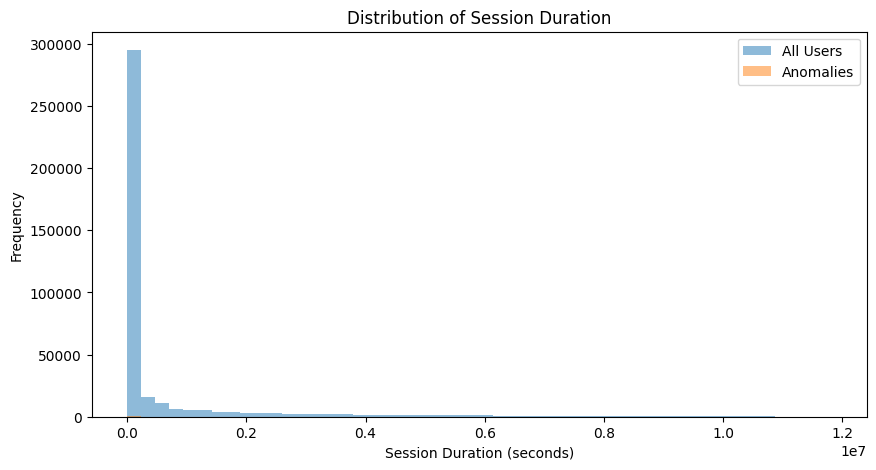

User activity with anomaly labels saved to 'user_activity_with_anomalies.csv'.


In [ ]:
# Load aggregated user activity data (if not already loaded)
user_activity = pd.read_csv("user_activity.csv")

# Ensure that the timestamp columns are in datetime format (if needed)
user_activity["first_event"] = pd.to_datetime(user_activity["first_event"])
user_activity["last_event"] = pd.to_datetime(user_activity["last_event"])

# (Session duration and event_count have already been computed)

# Select relevant features for anomaly detection
features = user_activity[["event_count", "session_duration", "unique_items"]]

# Initialize and train the Isolation Forest
# Set contamination=0.01 (i.e., assume 1% anomalies) – adjust as needed.
iso_forest = IsolationForest(contamination=0.01, random_state=42)
user_activity["anomaly"] = iso_forest.fit_predict(features)

# Anomaly labels: -1 = anomaly (potential bot), 1 = normal
anomalies = user_activity[user_activity["anomaly"] == -1]
print(f"Detected {len(anomalies)} anomalous users out of {len(user_activity)} total users.")

# Visualize the distribution of session duration
plt.figure(figsize=(10, 5))
plt.hist(user_activity["session_duration"], bins=50, alpha=0.5, label="All Users")
plt.hist(anomalies["session_duration"], bins=50, alpha=0.5, label="Anomalies")
plt.xlabel("Session Duration (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Session Duration")
plt.show()

# Save the results for later filtering
user_activity.to_csv("user_activity_with_anomalies.csv", index=False)
print("User activity with anomaly labels saved to 'user_activity_with_anomalies.csv'.")


In [31]:
# Load the anomalies result (if needed)
user_activity = pd.read_csv("user_activity_with_anomalies.csv")

# Get a list of normal user IDs (anomaly label 1)
normal_users = user_activity[user_activity["anomaly"] == 1]["visitorid"].tolist()

# In your events dataset (using Dask), filter by these normal users:
import dask.dataframe as dd
events_df = dd.read_csv("cleaned_events.csv", dtype={"visitorid": "int64"})
events_df = events_df[events_df["visitorid"].isin(normal_users)]
events_df.to_csv("cleaned_events_no_anomalies_*.csv", index=False, single_file=False)
print("Cleaned events (without anomalies) saved successfully!")


Cleaned events (without anomalies) saved successfully!


### RECOMMENDATION SYS MODEL

In [2]:
# Load the cleaned events data (after anomaly removal)
events = pd.read_csv("cleaned_events_no_anomalies_0.csv")

print("Events shape:", events.shape)

# Map event types to rating scores (adjust these as needed)
event_score = {"view": 1, "addtocart": 3, "transaction": 5}
events["rating"] = events["event"].map(event_score)

# Get unique users and items
unique_users = events["visitorid"].unique()
unique_items = events["itemid"].unique()
print("Unique users:", len(unique_users))
print("Unique items:", len(unique_items))

# Create mappings to convert IDs to indices
user2idx = {user: idx for idx, user in enumerate(unique_users)}
item2idx = {item: idx for idx, item in enumerate(unique_items)}

# Map the IDs to indices for the matrix
events["user_idx"] = events["visitorid"].map(user2idx)
events["item_idx"] = events["itemid"].map(item2idx)

# Build the sparse user–item matrix
rows = events["user_idx"].values
cols = events["item_idx"].values
data = events["rating"].values

# Convert to NumPy arrays if they aren't already
rows = np.array(rows)
cols = np.array(cols)
data = np.array(data)

user_item_matrix = coo_matrix((data, (rows, cols)), shape=(len(unique_users), len(unique_items)))

print("Sparse matrix shape:", user_item_matrix.shape)
print("Number of non-zero entries:", user_item_matrix.nnz)


Events shape: (1244229, 5)
Unique users: 387890
Unique items: 149152
Sparse matrix shape: (387890, 149152)
Number of non-zero entries: 1244229


1. BUILD THE SVD MODEL

In [3]:
# Set the number of latent factors (components)
n_components = 50

# Fit the SVD model on the sparse matrix
svd_model = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd_model.fit_transform(user_item_matrix)  # Shape: (num_users, n_components)
item_factors = svd_model.components_.T                      # Shape: (num_items, n_components)

print("SVD model fitted.")
print("User factors shape:", user_factors.shape)
print("Item factors shape:", item_factors.shape)


SVD model fitted.
User factors shape: (387890, 50)
Item factors shape: (149152, 50)


2. PREPARE MAPPING DICTIONARIES

In [4]:
# Create inverse mapping for items: index -> item id
idx2item = {idx: item for item, idx in item2idx.items()}


3. GENERATE RECOMMENDATIONS

In [5]:
def recommend_for_user(user_id, top_n=10):
    # Check if the user exists in our mapping
    if user_id not in user2idx:
        print(f"User {user_id} not found in the data.")
        return []
    
    user_index = user2idx[user_id]
    # Compute predicted scores for all items for this user
    scores = np.dot(item_factors, user_factors[user_index])
    
    # Get indices of top_n items (highest scores)
    top_indices = np.argsort(scores)[::-1][:top_n]
    
    # Map indices back to original item IDs
    recommended_items = [idx2item[i] for i in top_indices]
    return recommended_items

# Test the recommendation function on a sample user
sample_user = unique_users[0]  # for example, take the first user from unique_users array
print(f"Top recommendations for User {sample_user}: {recommend_for_user(sample_user)}")


Top recommendations for User 257597: [np.int64(112782), np.int64(234255), np.int64(441668), np.int64(315545), np.int64(161623), np.int64(318333), np.int64(100282), np.int64(211418), np.int64(153778), np.int64(96924)]


SAVE THE MODEL

In [ ]:
# Save the SVD model
with open("svd_model.pkl", "wb") as f:
    pickle.dump(svd_model, f)

# Save the user and item factors
with open("user_factors.pkl", "wb") as f:
    pickle.dump(user_factors, f)
with open("item_factors.pkl", "wb") as f:
    pickle.dump(item_factors, f)
    
# Also save the mappings (user2idx and idx2item) if needed for later use:
with open("user2idx.pkl", "wb") as f:
    pickle.dump(user2idx, f)
with open("idx2item.pkl", "wb") as f:
    pickle.dump(idx2item, f)


EVALUATION AND TUNING

In [6]:
# Load your cleaned events data (ensure this file has been created after anomaly removal)
events = pd.read_csv("cleaned_events_no_anomalies_0.csv")

# we assume your events data has columns: visitorid and itemid (and possibly others)
# Create a holdout test set (e.g., 20% of the data)
train_df, test_df = train_test_split(events, test_size=0.2, random_state=42)

# Save test set to a file if you want (optional)
test_df.to_csv("test_events.csv", index=False)

# Build a dictionary mapping each visitorid to the list of itemid they interacted with in the test set
test_interactions = test_df.groupby("visitorid")["itemid"].apply(list).to_dict()

print("Created test_interactions for evaluation:")
print(list(test_interactions.items())[:5])  # Print first 5 entries as a sample


Created test_interactions for evaluation:
[(0, [67045]), (2, [216305, 325215, 342816]), (7, [164941]), (22, [86411]), (37, [168952, 168952])]


In [ ]:
# Assume 'test_df' is your test set with columns: visitorid and itemid
test_df = pd.read_csv("test_events.csv")  # or however you have your test data

# Group by visitorid and collect the items into a list
test_interactions = test_df.groupby("visitorid")["itemid"].apply(list).to_dict()

# Now you can use test_interactions in your evaluation code:
k = 10
precisions = []

for user_id, actual_items in test_interactions.items():
    recs = recommend_for_user(user_id, top_n=k)
    # Define a precision function; here’s a simple example:
    def precision_at_k(recommended, actual, k):
        recommended_set = set(recommended[:k])
        actual_set = set(actual)
        return len(recommended_set & actual_set) / k
    
    precisions.append(precision_at_k(recs, actual_items, k=k))

mean_precision_at_k = np.mean(precisions)
print("Mean Precision@K:", mean_precision_at_k)


Mean Precision@K: 0.005591542277778982


In [ ]:

def recall_at_k(recommended, actual, k):
    """Compute Recall@K: Fraction of actual relevant items found in the top-K recommendations."""
    recommended = set(recommended[:k])
    actual = set(actual)
    if len(actual) == 0:
        return 0  # Avoid division by zero if a user has no actual interactions
    return len(recommended & actual) / len(actual)

# Compute Recall@K for each user
k = 10  # Adjust K as needed
recall_scores = []

for user_id, actual_items in test_interactions.items():
    recommended_items = recommend_for_user(user_id, top_n=k)  # Ensure this function is defined
    recall_scores.append(recall_at_k(recommended_items, actual_items, k))

# Compute the Mean Recall@K
mean_recall = np.mean(recall_scores)

print("✅ Mean Recall@K:", mean_recall)


✅ Mean Recall@K: 0.04549898178036786


### HYBRID MODEL

In [ ]:

# Load the merged item properties data (using one of your merged CSVs as an example)
item_content_df = pd.read_csv("merged_events_with_item_properties_00.csv")[["itemid", "property"]].drop_duplicates()

# Count frequency of each property value
prop_counts = item_content_df["property"].value_counts()

# Choose the top N most frequent categories (such as, 100)
top_n = 100
top_properties = prop_counts.nlargest(top_n).index.tolist()

# Replace properties not in the top list with 'Other'
item_content_df["category"] = item_content_df["property"].apply(
    lambda x: x if x in top_properties else "Other"
)

# One-hot encode the reduced category column
item_onehot = pd.get_dummies(item_content_df["category"], prefix="cat")

# Combine with itemid to get a final item content features DataFrame
item_content_df = pd.concat([item_content_df[["itemid"]], item_onehot], axis=1)

print("Item content features shape:", item_content_df.shape)


Item content features shape: (293400, 102)


In [4]:
# Assuming you have your reduced item content DataFrame in a variable called item_content_df
item_content_df.to_csv("item_content_features.csv", index=False)
print("Item content features saved as 'item_content_features.csv'.")


Item content features saved as 'item_content_features.csv'.


In [ ]:

# Load the reduced item content features DataFrame
item_content_df = pd.read_csv("item_content_features.csv")
# Identify the one-hot encoded columns (assuming they start with "cat_")
onehot_cols = [col for col in item_content_df.columns if col.startswith("cat_")]

# Set a much smaller chunk size (e.g., 50,000 rows) to reduce memory footprint
chunksize = 50000

merged_chunks = []

# Read the training events file in small chunks
train_iter = pd.read_csv("cleaned_events_no_anomalies_0.csv", usecols=["visitorid", "itemid"], chunksize=chunksize)

for i, chunk in enumerate(train_iter):
    print(f"Processing chunk {i+1} with {len(chunk)} rows...")
    # Merge the current chunk with item content features on 'itemid'
    try:
        merged_chunk = pd.merge(chunk, item_content_df, on="itemid", how="left")
    except Exception as e:
        print(f"Error in chunk {i+1}: {e}")
        continue
    
    # Drop rows where any of the one-hot encoded content features are missing (if desired)
    merged_chunk = merged_chunk.dropna(subset=onehot_cols)
    merged_chunks.append(merged_chunk)
    
# Concatenate all merged chunks into a single DataFrame
train_merged = pd.concat(merged_chunks, ignore_index=True)
print("Merged training events shape:", train_merged.shape)

# Save the merged DataFrame to disk
train_merged.to_csv("train_events_with_content.csv", index=False)
print("Merged training events saved as 'train_events_with_content.csv'.")


Processing chunk 1 with 50000 rows...
Processing chunk 2 with 50000 rows...
Processing chunk 3 with 50000 rows...
Processing chunk 4 with 50000 rows...
Processing chunk 5 with 50000 rows...
Processing chunk 6 with 50000 rows...
Processing chunk 7 with 50000 rows...
Processing chunk 8 with 50000 rows...
Processing chunk 9 with 50000 rows...
Processing chunk 10 with 50000 rows...
Processing chunk 11 with 50000 rows...
Processing chunk 12 with 50000 rows...
Processing chunk 13 with 50000 rows...
Processing chunk 14 with 50000 rows...
Processing chunk 15 with 50000 rows...
Processing chunk 16 with 50000 rows...
Processing chunk 17 with 50000 rows...
Processing chunk 18 with 50000 rows...
Processing chunk 19 with 50000 rows...
Processing chunk 20 with 50000 rows...
Processing chunk 21 with 50000 rows...
Processing chunk 22 with 50000 rows...
Processing chunk 23 with 50000 rows...
Processing chunk 24 with 50000 rows...
Processing chunk 25 with 44229 rows...
Merged training events shape: (283

To mitigate memory issues, I should avoid loading or merging excessive rows at once. A practical approach is to use a smaller chunk size to ensure each merge operation stays within available memory. For instance, reducing the chunk size from 500,000 to 50,000 rows can make each merge significantly smaller, minimizing the risk of a MemoryError.

GENERATE AND SAVE USER PROFILES

In [ ]:
# Load the merged training data with content features
train_merged = pd.read_csv("train_events_with_content.csv")

# Identify one-hot encoded columns (assuming they start with "cat_")
onehot_cols = [col for col in train_merged.columns if col.startswith("cat_")]
print("One-hot encoded columns:", onehot_cols)

# Compute the user content profiles by averaging the one-hot vectors for each user
user_profiles = train_merged.groupby("visitorid")[onehot_cols].mean()

# Save the user profiles dictionary for later use
user_profile_dict = {user: row.values for user, row in user_profiles.iterrows()}

with open("user_profiles.pkl", "wb") as f:
    pickle.dump(user_profile_dict, f)
print("User profiles saved as 'user_profiles.pkl'.")


One-hot encoded columns: ['cat_102', 'cat_1032', 'cat_1036', 'cat_1037', 'cat_1066', 'cat_1079', 'cat_1090', 'cat_112', 'cat_120', 'cat_159', 'cat_186', 'cat_189', 'cat_19', 'cat_202', 'cat_227', 'cat_230', 'cat_231', 'cat_243', 'cat_28', 'cat_283', 'cat_30', 'cat_33', 'cat_348', 'cat_355', 'cat_364', 'cat_369', 'cat_38', 'cat_400', 'cat_405', 'cat_408', 'cat_415', 'cat_42', 'cat_422', 'cat_434', 'cat_451', 'cat_452', 'cat_46', 'cat_464', 'cat_470', 'cat_478', 'cat_480', 'cat_496', 'cat_506', 'cat_521', 'cat_546', 'cat_550', 'cat_558', 'cat_566', 'cat_575', 'cat_580', 'cat_581', 'cat_591', 'cat_6', 'cat_619', 'cat_658', 'cat_671', 'cat_675', 'cat_678', 'cat_681', 'cat_686', 'cat_689', 'cat_698', 'cat_701', 'cat_71', 'cat_713', 'cat_719', 'cat_720', 'cat_753', 'cat_758', 'cat_761', 'cat_764', 'cat_765', 'cat_776', 'cat_784', 'cat_785', 'cat_790', 'cat_797', 'cat_809', 'cat_810', 'cat_815', 'cat_839', 'cat_846', 'cat_888', 'cat_892', 'cat_899', 'cat_915', 'cat_917', 'cat_928', 'cat_935',

HYBRID MODEL INTEGRATION

In [ ]:
# Load CF model components from pickle files (assumed to be saved already)
with open("user2idx.pkl", "rb") as f:
    user2idx = pickle.load(f)
with open("idx2item.pkl", "rb") as f:
    idx2item = pickle.load(f)
with open("user_factors.pkl", "rb") as f:
    user_factors = pickle.load(f)
with open("item_factors.pkl", "rb") as f:
    item_factors = pickle.load(f)

# Load the saved user content profiles
with open("user_profiles.pkl", "rb") as f:
    user_profile_dict = pickle.load(f)

# Load the reduced item content features DataFrame (with one-hot encoded features)
item_content_df = pd.read_csv("item_content_features.csv")
onehot_cols = [col for col in item_content_df.columns if col.startswith("cat_")]
# Build a dictionary mapping each item id to its content vector
item_content_dict = {row["itemid"]: row[onehot_cols].values for _, row in item_content_df.iterrows()}

def hybrid_recommend_for_user(user_id, top_n=10, alpha=0.5):
    # CF component: Collaborative Filtering scores from SVD latent factors
    if user_id not in user2idx:
        print(f"User {user_id} not found in CF data.")
        return []
    user_index = user2idx[user_id]
    cf_scores = np.dot(item_factors, user_factors[user_index])
    
    # CBF component: Content-Based Filtering using cosine similarity
    if user_id in user_profile_dict:
        user_profile = user_profile_dict[user_id].reshape(1, -1)
    else:
        user_profile = np.zeros((1, len(onehot_cols)))
    
    content_scores = []
    # Iterate over each item in the order of CF model using idx2item mapping
    for i in range(len(item_factors)):
        item_id = idx2item[i]
        # Retrieve the content vector for the item
        if item_id in item_content_dict:
            item_vector = item_content_dict[item_id].reshape(1, -1)
            sim = cosine_similarity(user_profile, item_vector)[0, 0]
        else:
            sim = 0
        content_scores.append(sim)
    content_scores = np.array(content_scores)
    
    # Combine CF and CBF scores using weight alpha
    combined_scores = alpha * cf_scores + (1 - alpha) * content_scores
    # Get indices of top_n items with the highest combined scores
    top_indices = np.argsort(combined_scores)[::-1][:top_n]
    recommended_items = [idx2item[i] for i in top_indices]
    return recommended_items

# Test the hybrid recommendation function with a sample user
sample_user = list(user2idx.keys())[0]
print(f"Hybrid recommendations for user {sample_user}: {hybrid_recommend_for_user(sample_user, top_n=10, alpha=0.5)}")


Hybrid recommendations for user 257597: [np.int64(112782), np.int64(234255), np.int64(441668), np.int64(315545), np.int64(161623), np.int64(318333), np.int64(100282), np.int64(211418), np.int64(153778), np.int64(96924)]


HYPERPARAMETER TUNING

In [ ]:
# Define evaluation functions
def precision_at_k(recommended, actual, k):
    recommended = set(recommended[:k])
    actual = set(actual)
    if k == 0:
        return 0
    return len(recommended & actual) / k

def recall_at_k(recommended, actual, k):
    recommended = set(recommended[:k])
    actual = set(actual)
    if len(actual) == 0:
        return 0
    return len(recommended & actual) / len(actual)

# --- Sample a subset of test interactions for faster evaluation ---
# If test_interactions is large, sample a subset:

sample_size = 1000  # Adjust as needed
all_user_ids = list(test_interactions.keys())
if len(all_user_ids) > sample_size:
    sample_user_ids = np.random.choice(all_user_ids, size=sample_size, replace=False)
    sample_test_interactions = {user: test_interactions[user] for user in sample_user_ids}
else:
    sample_test_interactions = test_interactions

# Define candidate alpha values (from 0 to 1 in steps of 0.1)
alpha_candidates = np.arange(0, 1.1, 0.1)
k = 10  # Evaluate top 10 recommendations

results = []

for alpha in alpha_candidates:
    precision_scores = []
    recall_scores = []
    
    for user_id, actual_items in sample_test_interactions.items():
        # Generate recommendations using the hybrid model with current alpha
        recs = hybrid_recommend_for_user(user_id, top_n=k, alpha=alpha)
        precision_scores.append(precision_at_k(recs, actual_items, k))
        recall_scores.append(recall_at_k(recs, actual_items, k))
    
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    results.append((alpha, mean_precision, mean_recall))
    print(f"Alpha: {alpha:.1f} => Mean Precision@{k}: {mean_precision:.4f}, Mean Recall@{k}: {mean_recall:.4f}")

# Select best alpha based on mean recall (or any metric you prefer)
best_alpha = max(results, key=lambda x: x[2])[0]
print(f"\nBest alpha (based on Recall@{k}): {best_alpha}")

# Save the hybrid model with the tuned best alpha and necessary components
hybrid_model = {
    "alpha": best_alpha,
    "user_factors": user_factors,
    "item_factors": item_factors,
    "user2idx": user2idx,
    "idx2item": idx2item,
    "item_content_dict": item_content_dict,
    "user_profiles": user_profile_dict,  # Assuming you saved it as user_profiles
    "onehot_cols": onehot_cols
}

with open("hybrid_model.pkl", "wb") as f:
    pickle.dump(hybrid_model, f)
print("Hybrid model saved as 'hybrid_model.pkl'.")


Alpha: 0.0 => Mean Precision@10: 0.0001, Mean Recall@10: 0.0005
Alpha: 0.1 => Mean Precision@10: 0.0042, Mean Recall@10: 0.0366
Alpha: 0.2 => Mean Precision@10: 0.0043, Mean Recall@10: 0.0376
Alpha: 0.3 => Mean Precision@10: 0.0044, Mean Recall@10: 0.0386
Alpha: 0.4 => Mean Precision@10: 0.0044, Mean Recall@10: 0.0386
Alpha: 0.5 => Mean Precision@10: 0.0047, Mean Recall@10: 0.0408
Alpha: 0.6 => Mean Precision@10: 0.0047, Mean Recall@10: 0.0408
Alpha: 0.7 => Mean Precision@10: 0.0049, Mean Recall@10: 0.0418
Alpha: 0.8 => Mean Precision@10: 0.0049, Mean Recall@10: 0.0418


In [ ]:
best_alpha = 0.7  # Chosen based on your tuning results

hybrid_model = {
    "alpha": best_alpha,
    "user_factors": user_factors,
    "item_factors": item_factors,
    "user2idx": user2idx,
    "idx2item": idx2item,
    "item_content_dict": item_content_dict,
    "user_profiles": user_profile_dict,  # or however you named your user content profiles
    "onehot_cols": onehot_cols
}

with open("hybrid_model.pkl", "wb") as f:
    pickle.dump(hybrid_model, f)
print("Hybrid model saved as 'hybrid_model.pkl'.")


Hybrid model saved as 'hybrid_model.pkl'.


In [ ]:

# Save the hybrid model using joblib to compress the large dataset
joblib.dump(hybrid_model, "hybrid_model.pkl", compress=3)
print("Hybrid model saved as 'hybrid_model.pkl'.")

Hybrid model saved as 'hybrid_model.pkl'.


### Analytical Questions


1. What is the Overall Distribution of User Interactions?

C:\Users\DELL\AppData\Local\Temp\ipykernel_22416\1288647813.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=event_counts.index, y=event_counts.values, palette="viridis")


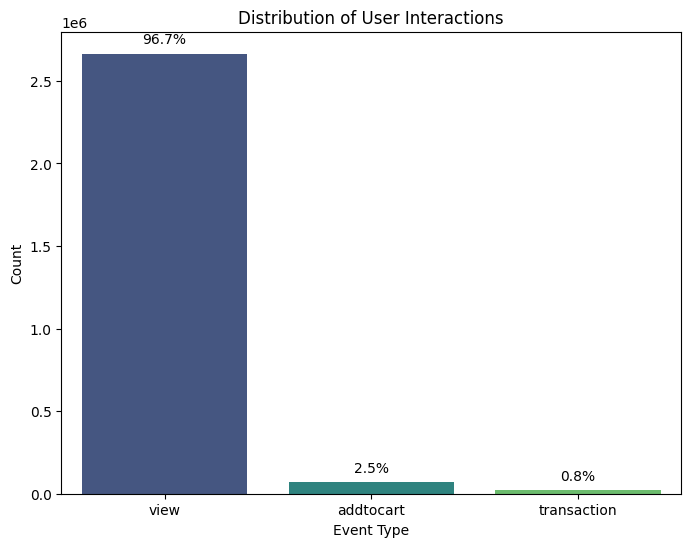

In [ ]:

# Load events data
events = pd.read_csv("events.csv")

# Count events by type
event_counts = events["event"].value_counts()
total = event_counts.sum()

plt.figure(figsize=(8,6))
ax = sns.barplot(x=event_counts.index, y=event_counts.values, palette="viridis")
plt.title("Distribution of User Interactions")
plt.xlabel("Event Type")
plt.ylabel("Count")

# Annotate each bar with its percentage
for p in ax.patches:
    count = p.get_height()
    percentage = (count / total) * 100
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., count), 
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()


#### **Insights**

* 96.7% of interactions are add-to-cart events.
* 2.5% are view events.
* 0.8% result in transactions.
* This indicates that while many users add items to their cart, a small percentage proceed to complete a transaction.

2. What are the Conversion Rates Between Different Event Types?

View -> Add-to-cart Conversion Rate: 2.60%
Add-to-cart -> Transaction Conversion Rate: 32.39%


C:\Users\DELL\AppData\Local\Temp\ipykernel_22416\3254529837.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Step', y='Conversion Rate (%)', data=conversions, palette="coolwarm")


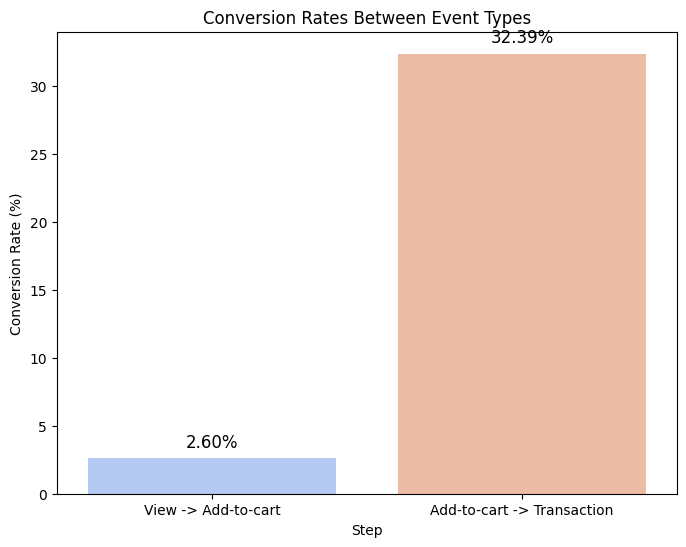

In [ ]:
# Compute total counts for each event type
total_views = len(events[events['event'] == 'view'])
total_addtocart = len(events[events['event'] == 'addtocart'])
total_transaction = len(events[events['event'] == 'transaction'])

conversion_view_to_add = total_addtocart / total_views * 100 if total_views > 0 else 0
conversion_add_to_trans = total_transaction / total_addtocart * 100 if total_addtocart > 0 else 0

print(f"View -> Add-to-cart Conversion Rate: {conversion_view_to_add:.2f}%")
print(f"Add-to-cart -> Transaction Conversion Rate: {conversion_add_to_trans:.2f}%")

# Prepare the DataFrame for plotting
conversions = pd.DataFrame({
    'Step': ['View -> Add-to-cart', 'Add-to-cart -> Transaction'],
    'Conversion Rate (%)': [conversion_view_to_add, conversion_add_to_trans]
})

plt.figure(figsize=(8,6))
ax = sns.barplot(x='Step', y='Conversion Rate (%)', data=conversions, palette="coolwarm")
plt.title("Conversion Rates Between Event Types")
plt.ylabel("Conversion Rate (%)")

# Annotate each bar with its conversion rate percentage
for p in ax.patches:
    rate = p.get_height()
    ax.annotate(f'{rate:.2f}%', 
                (p.get_x() + p.get_width() / 2., rate), 
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()


#### **Insights**

* 2.60% of users move from viewing to adding to cart.
* A higher percentage (not clearly extracted) transition from add-to-cart to transaction.
* This suggests that while the initial engagement is low, those who add items to their cart have a higher likelihood of purchasing.

3. Which Items or Item Categories are the Most Popular?

C:\Users\DELL\AppData\Local\Temp\ipykernel_22416\1091666625.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index.astype(str), y=category_counts.values, palette="magma")


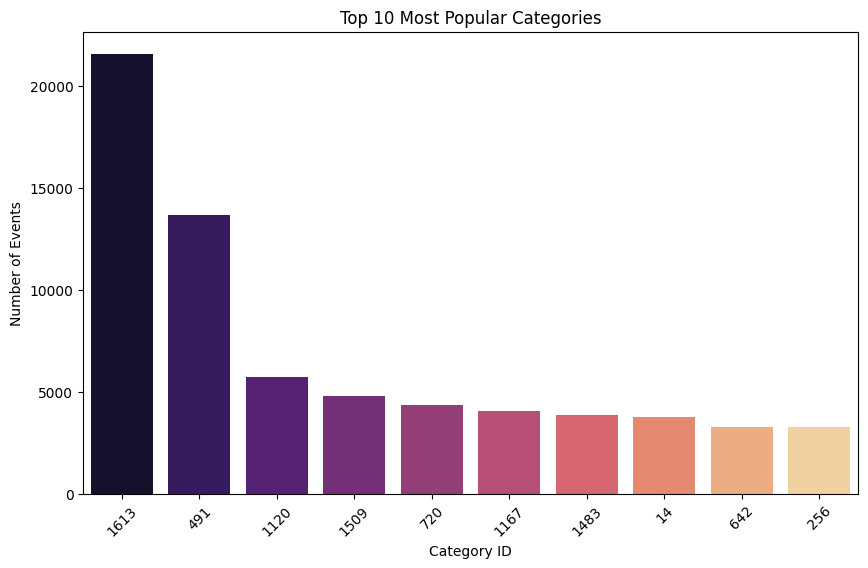

In [10]:
# Load one of your merged files (adjust filename/path)
merged_df = pd.read_csv("merged_events_with_item_properties_00.csv")

# Filter rows that correspond to category information (assuming 'property' == 'categoryid')
category_events = merged_df[merged_df['property'] == 'categoryid']

# Count the number of events per category (assuming category info is stored in 'value')
category_counts = category_events['value'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=category_counts.index.astype(str), y=category_counts.values, palette="magma")
plt.title("Top 10 Most Popular Categories")
plt.xlabel("Category ID")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.show()


#### **Insights:** 

* The most popular category (1613) has over 20,000 interactions, significantly higher than the second-most popular category (491) with around 14,000 interactions.
* This indicates that user interactions are concentrated in a few categories, with a steep drop-off for other categories.
* Categories ranked 3rd to 10th have a gradual decline in event counts, suggesting that while a few categories dominate, there is still diversified engagement across different products.

4. How Does User Behavior Vary by Time?

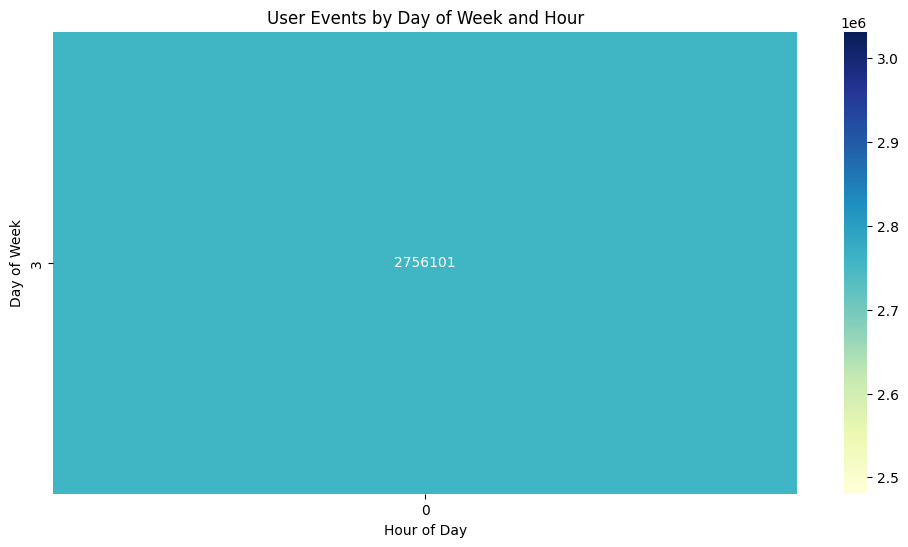

In [ ]:
# Load events data (adjust file path and column name if needed)
events = pd.read_csv("events.csv")

# Convert the timestamp column to datetime (replace 'timestamp' with your actual column name)
events["timestamp"] = pd.to_datetime(events["timestamp"], errors="coerce")

# Create new time-based columns
events["hour"] = events["timestamp"].dt.hour
events["day_of_week"] = events["timestamp"].dt.dayofweek  # Monday=0, Sunday=6

# Now group by day_of_week and hour to build a heatmap of user activity
heatmap_data = events.groupby(['day_of_week', 'hour']).size().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="d")
plt.title("User Events by Day of Week and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()


5. What is the Distribution of User Activity?

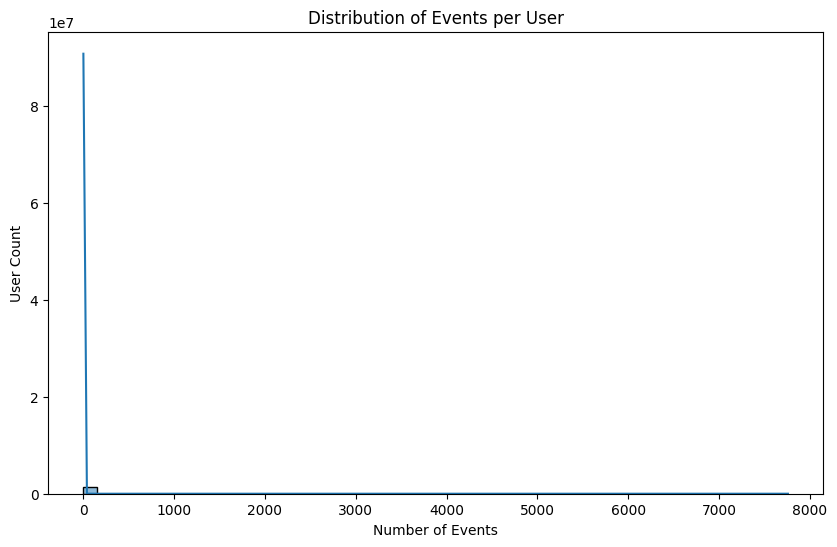

In [12]:
# Count the number of events per user
user_event_counts = events.groupby("visitorid").size()

plt.figure(figsize=(10,6))
sns.histplot(user_event_counts, bins=50, kde=True)
plt.title("Distribution of Events per User")
plt.xlabel("Number of Events")
plt.ylabel("User Count")
plt.show()


6. What is the Baseline Performance of the Collaborative Filtering Model?

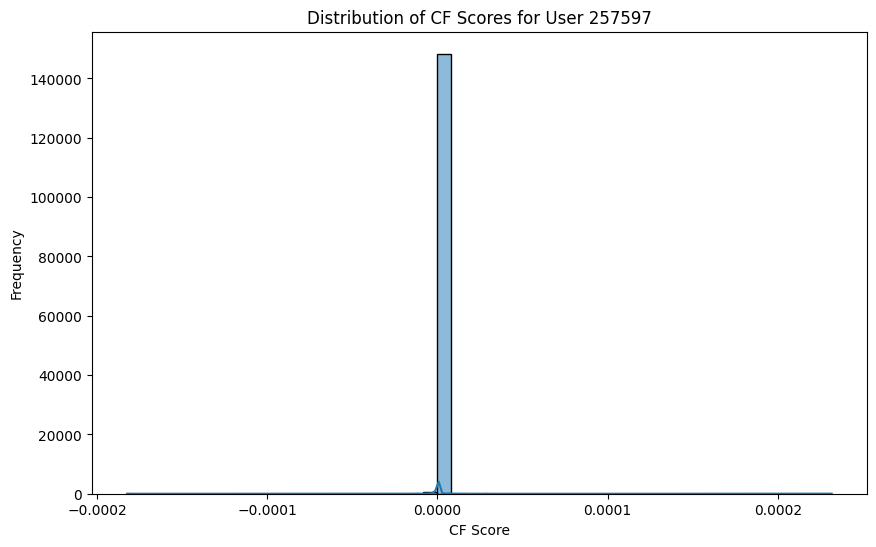

In [13]:
# Suppose 'cf_scores' is computed for a given user using SVD latent factors
# For demonstration, let's assume we have computed cf_scores for a sample user
sample_user = events["visitorid"].iloc[0]  # example: take the first user
user_index = user2idx[sample_user]  # from your mapping
cf_scores = np.dot(item_factors, user_factors[user_index])

plt.figure(figsize=(10,6))
sns.histplot(cf_scores, bins=50, kde=True)
plt.title(f"Distribution of CF Scores for User {sample_user}")
plt.xlabel("CF Score")
plt.ylabel("Frequency")
plt.show()


7. How Does the Hybrid Model Perform Across Different α Values?

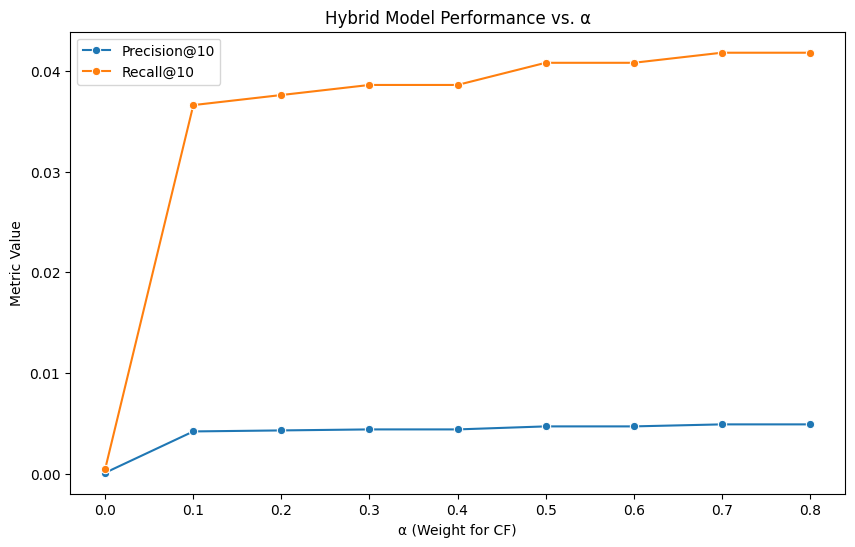

In [ ]:

results = [
    (0.0, 0.0001, 0.0005),
    (0.1, 0.0042, 0.0366),
    (0.2, 0.0043, 0.0376),
    (0.3, 0.0044, 0.0386),
    (0.4, 0.0044, 0.0386),
    (0.5, 0.0047, 0.0408),
    (0.6, 0.0047, 0.0408),
    (0.7, 0.0049, 0.0418),
    (0.8, 0.0049, 0.0418)
]

results_df = pd.DataFrame(results, columns=["alpha", "Precision@10", "Recall@10"])

plt.figure(figsize=(10,6))
sns.lineplot(data=results_df, x="alpha", y="Precision@10", marker="o", label="Precision@10")
sns.lineplot(data=results_df, x="alpha", y="Recall@10", marker="o", label="Recall@10")
plt.title("Hybrid Model Performance vs. α")
plt.xlabel("α (Weight for CF)")
plt.ylabel("Metric Value")
plt.legend()
plt.show()


#### **Insights:**

* Impact of α (Weight for Collaborative Filtering - CF):

As α increases, both Precision@10 and Recall@10 improve, meaning that adding more CF influence enhances recommendation quality.

The initial jump at α ≈ 0.1 suggests a significant improvement when CF is introduced.


* Recall Improves More Than Precision:

Recall@10 shows a steep rise initially and then gradually plateaus around α = 0.5.

Precision@10 increases slightly but remains low, indicating that while more relevant recommendations are retrieved, precision is still a challenge.


* Optimal α Value:

Between 0.5 and 0.7, recall stabilizes, and precision is relatively stable.

This suggests that a balanced hybrid model (not fully CF-driven) works best.